let us start by importing the required functions

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
# import statsemodels.api as sm
import SALib
import seaborn as sns
import mpl_toolkits.axisartist as AA
import mpld3
import scipy as sp
import copy
import matplotlib.ticker as ticker

from ema_workbench import (Model, RealParameter, IntegerParameter, Policy, CategoricalParameter, Constant, TimeSeriesOutcome, ScalarOutcome, perform_experiments, ema_logging, save_results, load_results)
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS, SequentialEvaluator
from ema_workbench.connectors.pysd_connector import PysdModel 
from ema_workbench.connectors import vensimDLLwrapper
from ema_workbench.connectors.vensim import VensimModel
from ema_workbench.em_framework.samplers import sample_levers, sample_uncertainties
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.util import load_results
from ema_workbench.util import ema_logging

from ema_workbench.analysis import prim
from ema_workbench.analysis.plotting import lines, multiple_densities, kde_over_time
from ema_workbench.analysis.plotting_util import KDE
from ema_workbench.analysis.plotting_util import determine_time_dimension
from ema_workbench.analysis.pairs_plotting import pairs_scatter

from SALib.sample import saltelli
from SALib.analyze import sobol, morris
from SALib.test_functions import Ishigami

from mpl_toolkits.axes_grid1 import host_subplot

from scipy.stats import linregress

ema_logging.log_to_stderr(ema_logging.INFO)

C:\Users\guri_\Anaconda3\lib\site-packages\ema_workbench\connectors\__init__.py:18: ImportWarning: netlogo connector not available
  warnings.warn("netlogo connector not available", ImportWarning)


<Logger EMA (DEBUG)>

# Adding Reconversion Open Exploration  

In [3]:
vensimModel2 = VensimModel("Step3Model", model_file="ShortTermPolicyforObjectives_Step3.vpm" )

In [4]:
vensimModel2.uncertainties = [

            RealParameter("Average Fertility Rate", 0.01, 0.025),
            RealParameter("Average Mortality Rate", 0.00126, 0.00154),
            IntegerParameter("BASE Average Household size", 2, 7),
#             RealParameter("Fraction of people selling houses when leaving city", 0.1, 0.4),     
            RealParameter("average Immigration percent", 0.01, 0.06),
            RealParameter("Housing Area Per person", 0.000004, 0.000006),
            RealParameter("Floor Area Ratio", 2, 7),
            RealParameter("Average Residential approval period", 0.5, 2),
            RealParameter("Base Green Area commisioned per year", 0.02, 0.06),
            RealParameter("average green area construction period", 0.5, 2),
            RealParameter("Base Economic area Conversion rate", 0.01, 0.06),
            RealParameter("Base Slum reconversion rate", 0.01, 0.06),
            RealParameter("Fraction of people selling houses when leaving city", 0.1, 0.5),
            RealParameter("house construction time", 0.5, 2),
            IntegerParameter("time delay effect uncertainty of spending capacity on housing price", 1, 4),
            RealParameter("Slum dwelling area per person", 0.000004, 0.000006),
            RealParameter("Base residential conversion rate", 0.01, 0.05),
            RealParameter("average Emmigration percent", 0.008, 0.05),
            RealParameter("Relocation Rate", 0.001, 0.02), #for relocation of population on streets
            RealParameter("Average Commercial Approval Period", 0.5, 2),
            RealParameter("Base Green Area Reconversion rate", 0.001, 0.03),
            RealParameter("Average Slum Construction period", 0.1, 0.5),
            RealParameter("Average slum Demolition Period", 0.5, 2),
            RealParameter("uncertainty of average percent of inflation effect", 0.01, 0.08),
            RealParameter("average payment to income ratio for housing", 0.2, 0.5),
            RealParameter("Base Non Economic Reconv rate", 0.01 ,0.05),
            RealParameter("Ratio of Renting to Buying",0.2, 1),
            RealParameter("margin of empty housing",0.1,0.5)
]

vensimModel2.outcomes = [
    TimeSeriesOutcome('Housing Affordability Rating'),
    TimeSeriesOutcome('People with No Settlements'),
    TimeSeriesOutcome('Illegal Slum Population'),
    TimeSeriesOutcome('Urban Non Residential Area'),
    TimeSeriesOutcome('Urban Residential Land'),
    TimeSeriesOutcome('Slum Area'),
    TimeSeriesOutcome('Green Area'),
    TimeSeriesOutcome('Fraction of population living illegally')
    
]

In [5]:
results2 = perform_experiments(vensimModel2, 1500, uncertainty_sampling=LHS)

[MainProcess/INFO] performing 1500 scenarios * 1 policies * 1 model(s) = 1500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1050 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1350 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] experiments finished


In [5]:
results_name = './Step3Model_LHS_1500.tar.gz'
save_results(results2, results_name)

[MainProcess/INFO] results saved successfully to E:\Study\Delft\Papers\V2\Step3Model_LHS_1500.tar.gz


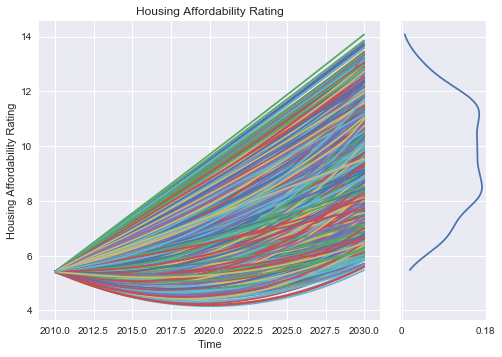

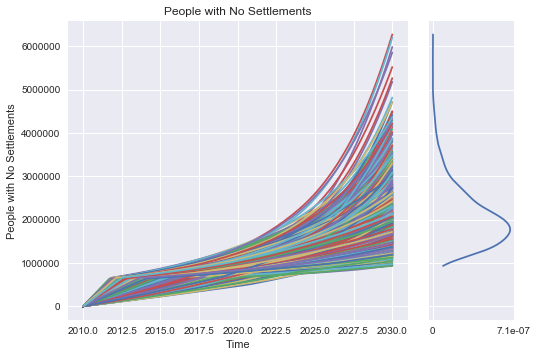

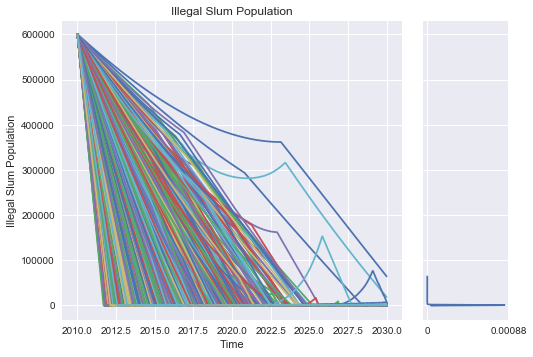

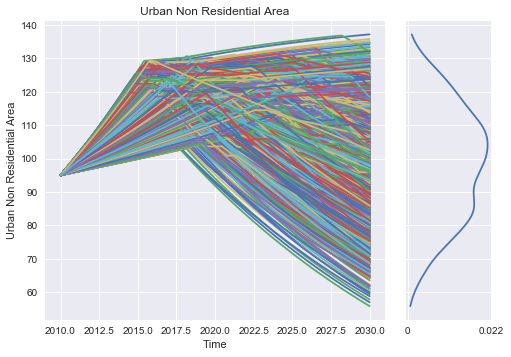

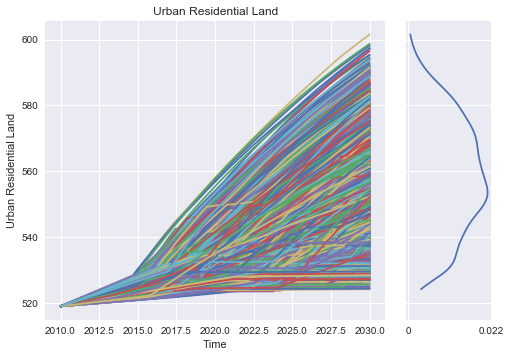

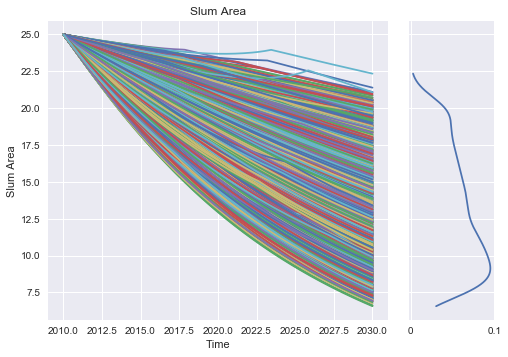

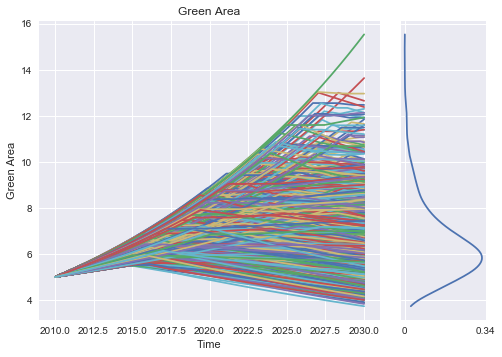

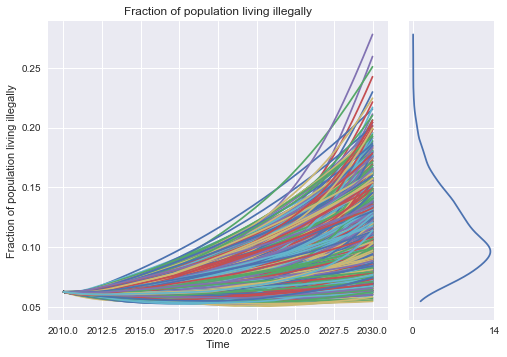

In [6]:
# import matplotlib.pyplot as plt
# from ema_workbench.analysis.plotting import lines 
# from ema_workbench.analysis.plotting_util import KDE

outputs = list(results2[1].keys())[1:] 

for x in outputs:
    fig = lines(results2, outcomes_to_show=[x], density=KDE)
plt.show()

In [2]:
results = load_results('./Step3Model_LHS_1500.tar.gz')

[MainProcess/INFO] results loaded succesfully from E:\Study\Delft\Papers\V2\Step3Model_LHS_1500.tar.gz


In [14]:
experiments, outcomes = results2

In [8]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyHAfford(data):
    ooi = 'Housing Affordability Rating'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>7] = 1
    return classes


prim_obj = prim.setup_prim(results, classifyHAfford, threshold=0.8)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 1500 points remaining, containing 755 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.24533333333333332, coverage: 0.48741721854304637, density: 1.0 restricted_dimensions: 2


In [9]:
box_1.show_tradeoff()
mpld3.display()

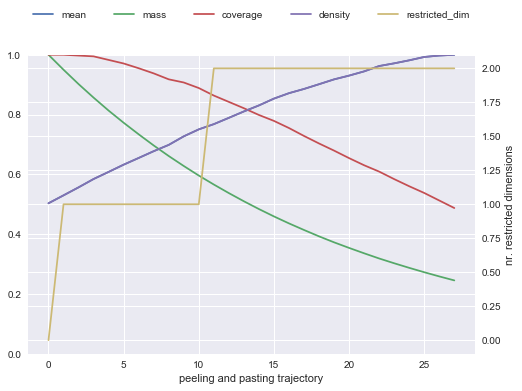

In [10]:
box_1.show_ppt()
plt.show()

coverage    0.798675
density     0.830579
mass           0.484
mean        0.830579
res dim            2
Name: 14, dtype: object

                                                      box 14            \
                                                         min       max   
average payment to income ratio for housing         0.321213  0.499946   
uncertainty of average percent of inflation effect  0.010046  0.066991   

                                                                  
                                                       qp values  
average payment to income ratio for housing         2.480876e-53  
uncertainty of average percent of inflation effect  1.357355e-07  



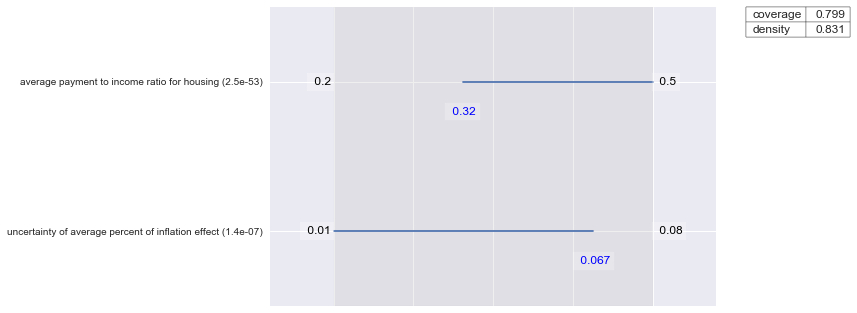

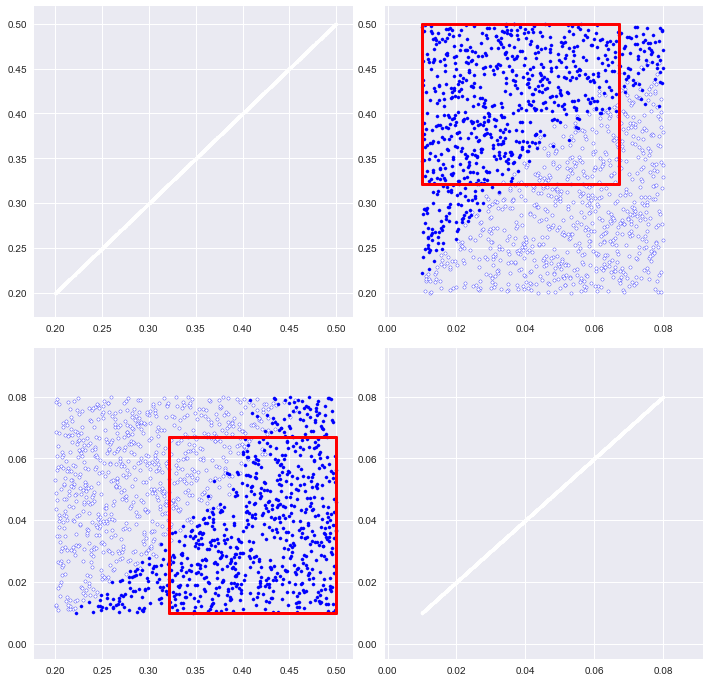

In [11]:
valuebox = 14
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [14]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyNoSettle(data):
    ooi = 'People with No Settlements'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>800000] = 1
    return classes


prim_obj = prim.setup_prim(results, classifyNoSettle, threshold=0.8)
box_2 = prim_obj.find_box()

[MainProcess/INFO] 1500 points remaining, containing 1268 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.39266666666666666, coverage: 0.4645110410094637, density: 1.0 restricted_dimensions: 5


In [15]:
box_2.show_tradeoff()
mpld3.display()

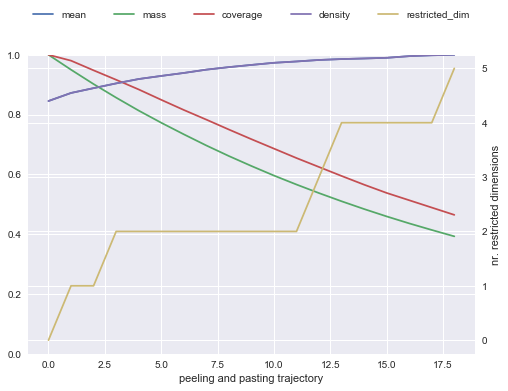

In [16]:
box_2.show_ppt()
plt.show()

coverage    0.594637
density     0.985621
mass            0.51
mean        0.985621
res dim            4
Name: 13, dtype: object

                                       box 13                        
                                          min       max     qp values
average Immigration percent          0.024961  0.059982  6.805819e-13
Base Slum reconversion rate          0.019463  0.059990  1.637563e-12
average Emmigration percent          0.010523  0.049989  2.338724e-01
Average Residential approval period  0.500326  1.902955  3.226729e-01



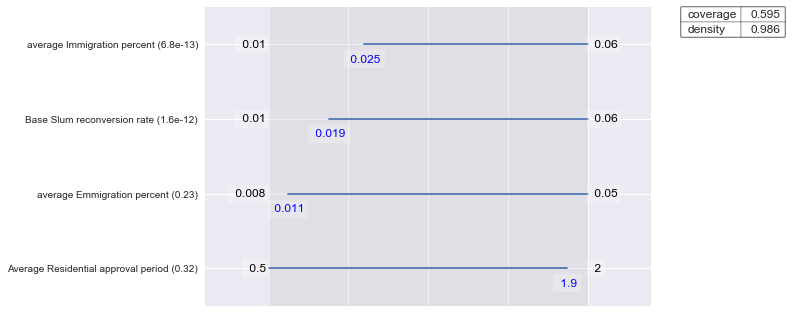

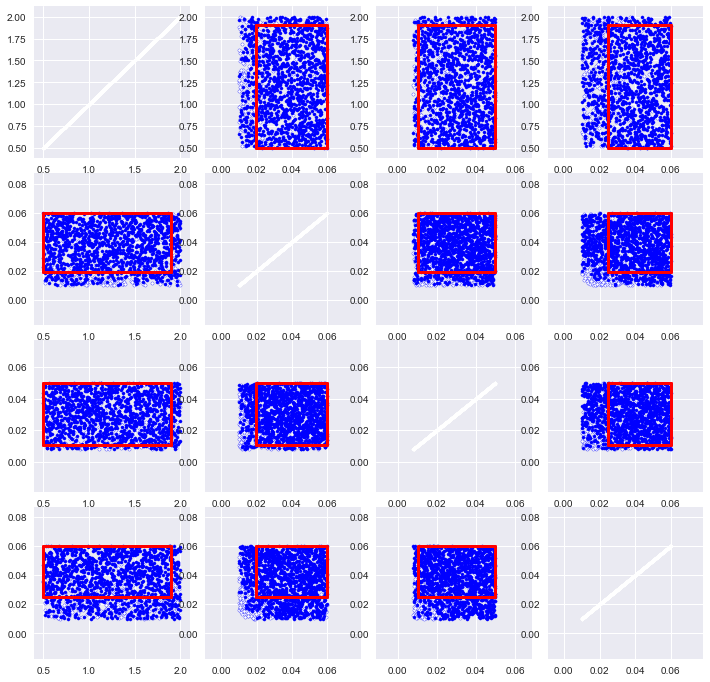

In [17]:
valuebox = 13
box_2.inspect(valuebox)
box_2.select(valuebox)

top_box = valuebox
box_2.inspect(top_box, style='graph')

fig = box_2.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

coverage    0.624606
density      0.98263
mass        0.537333
mean         0.98263
res dim            3
Name: 12, dtype: object

                               box 12                        
                                  min       max     qp values
Base Slum reconversion rate  0.019463  0.059990  8.327419e-13
average Immigration percent  0.024961  0.059982  1.194333e-12
average Emmigration percent  0.010523  0.049989  2.026546e-01



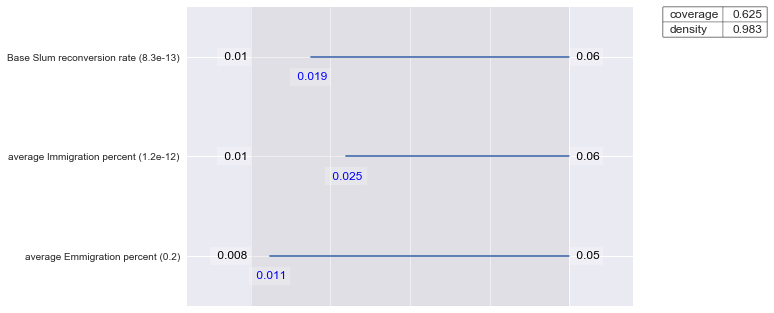

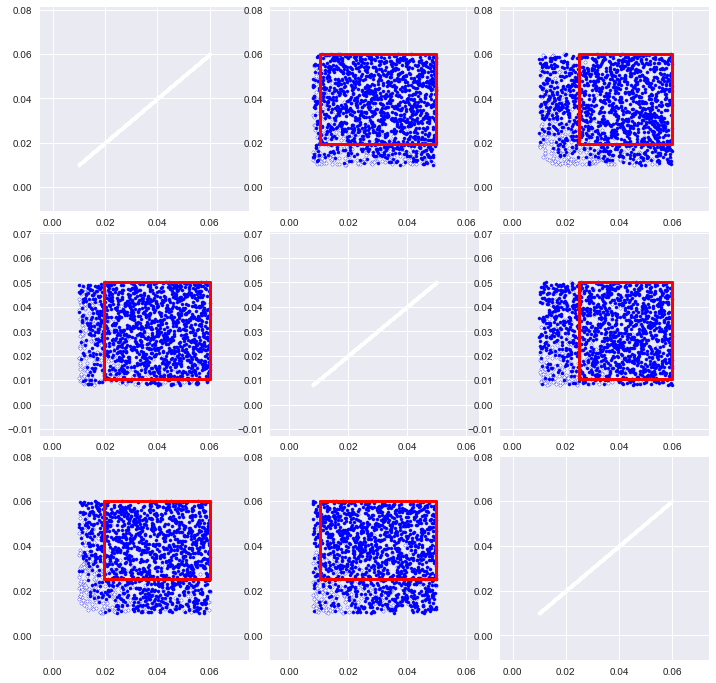

In [18]:
valuebox = 12
box_2.inspect(valuebox)
box_2.select(valuebox)

top_box = valuebox
box_2.inspect(top_box, style='graph')

fig = box_2.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [18]:
def classifyFracIllegal(data):
    ooi = 'Fraction of population living illegally'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>0.07] = 1
    return classes


prim_obj = prim.setup_prim(results2, classifyFracIllegal, threshold=0.8)
box_2 = prim_obj.find_box()

[MainProcess/INFO] 1500 points remaining, containing 1019 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.27266666666666667, coverage: 0.4013738959764475, density: 1.0 restricted_dimensions: 8


In [20]:
box_2.show_tradeoff()
mpld3.display()

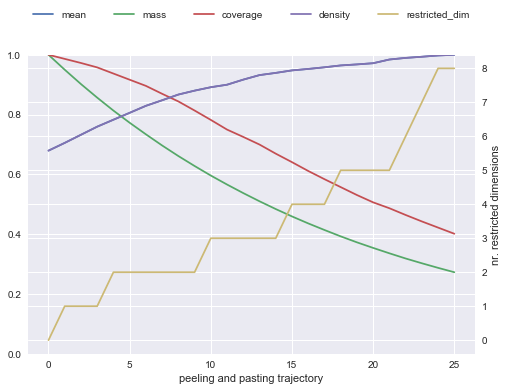

In [22]:
box_2.show_ppt()
plt.show()

coverage    0.782139
density     0.891499
mass           0.596
mean        0.891499
res dim            3
Name: 10, dtype: object

                               box 10                        
                                  min       max     qp values
average Emmigration percent  0.020689  0.049994  9.406197e-36
Base Slum reconversion rate  0.014700  0.059996  3.306594e-04
average Immigration percent  0.010000  0.057545  1.578981e-01



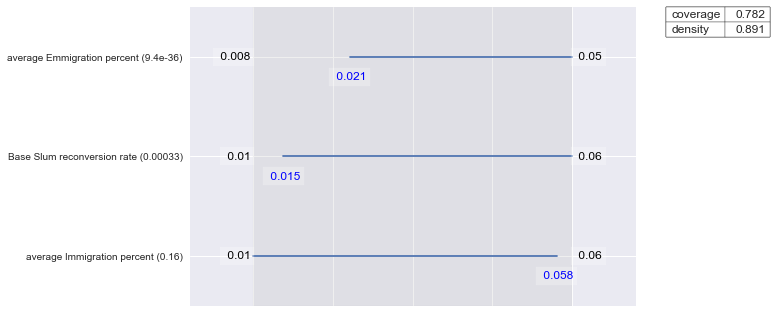

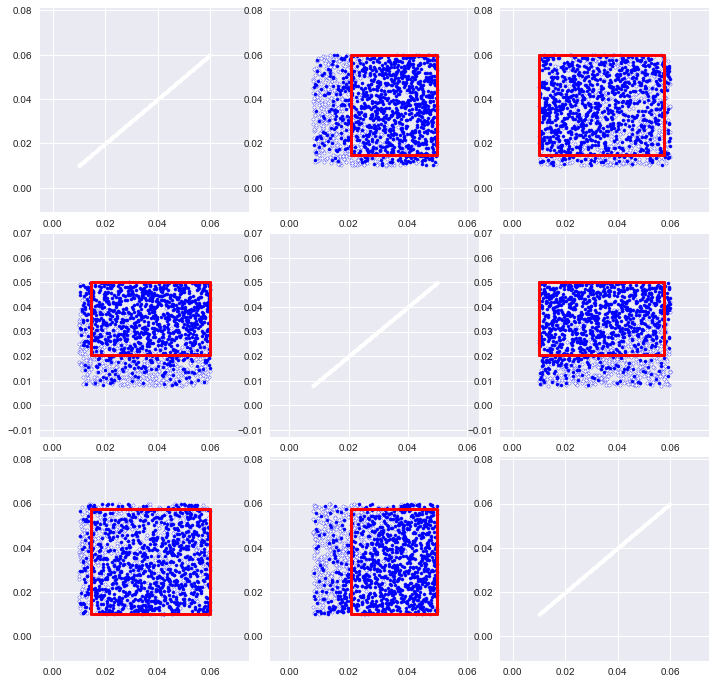

In [23]:
valuebox = 10
box_2.inspect(valuebox)
box_2.select(valuebox)

top_box = valuebox
box_2.inspect(top_box, style='graph')

fig = box_2.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [23]:
def classifyUrbanNon(data):
    ooi = 'Urban Non Residential Area'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome<115] = 1
    return classes


prim_obj = prim.setup_prim(results, classifyUrbanNon, threshold=0.75)
box_4 = prim_obj.find_box()

[MainProcess/INFO] 1500 points remaining, containing 1243 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.39266666666666666, coverage: 0.47385358004827033, density: 1.0 restricted_dimensions: 4


In [24]:
box_4.show_tradeoff()
mpld3.display()

coverage    0.672566
density     0.984688
mass           0.566
mean        0.984688
res dim            3
Name: 11, dtype: object

                                 box 11                        
                                    min       max     qp values
average Immigration percent    0.025218  0.059982  3.783098e-37
Base Non Economic Reconv rate  0.015540  0.049988  3.463320e-07
Base Slum reconversion rate    0.010027  0.057397  2.509334e-01



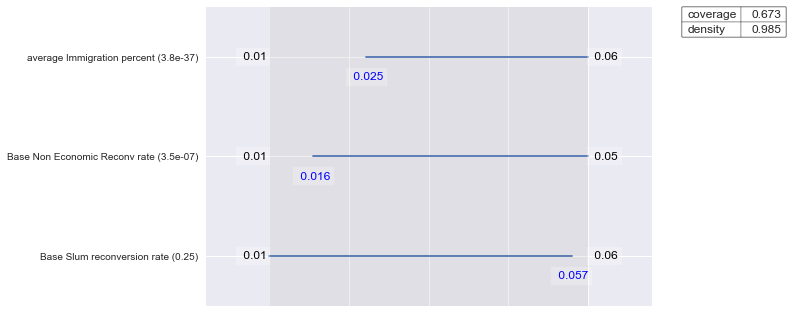

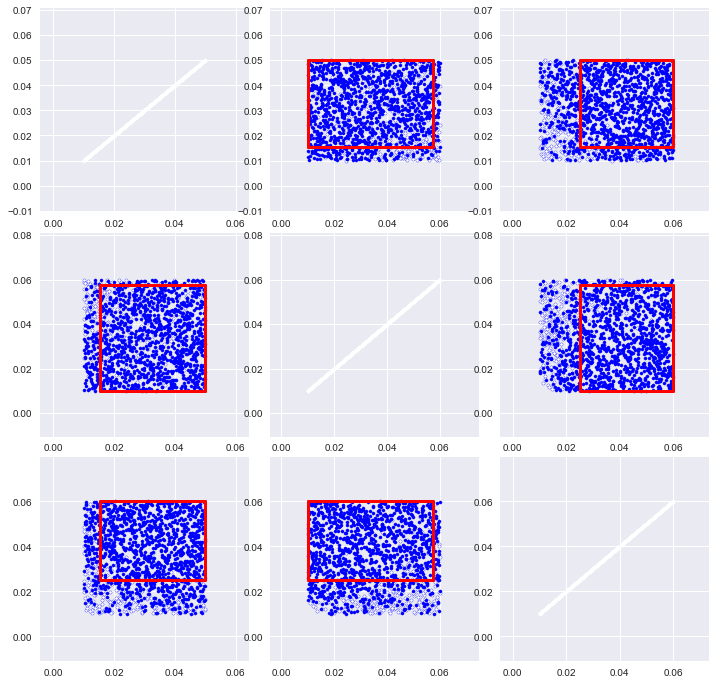

In [25]:
valuebox = 11
box_4.inspect(valuebox)
box_4.select(valuebox)

top_box = valuebox
box_4.inspect(top_box, style='graph')

fig = box_4.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [29]:
def classifyGreenA(data):
    ooi = 'Green Area'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome<7] = 1
    return classes


prim_obj = prim.setup_prim(results, classifyGreenA, threshold=0.8)
box_5 = prim_obj.find_box()

[MainProcess/INFO] 1500 points remaining, containing 1259 cases of interest
[MainProcess/INFO] mean: 0.9985611510791367, mass: 0.4633333333333333, coverage: 0.551231135822081, density: 0.9985611510791367 restricted_dimensions: 2


In [27]:
box_5.show_tradeoff()
mpld3.display()

coverage    0.551231
density     0.998561
mass        0.463333
mean        0.998561
res dim            2
Name: 18, dtype: object

                                        box 18                        
                                           min       max     qp values
Base Economic area Conversion rate    0.035790  0.059972  1.633955e-49
Base Green Area commisioned per year  0.020021  0.058653  4.292581e-01



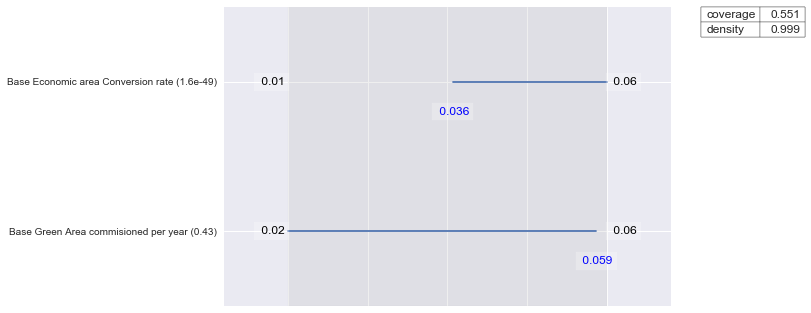

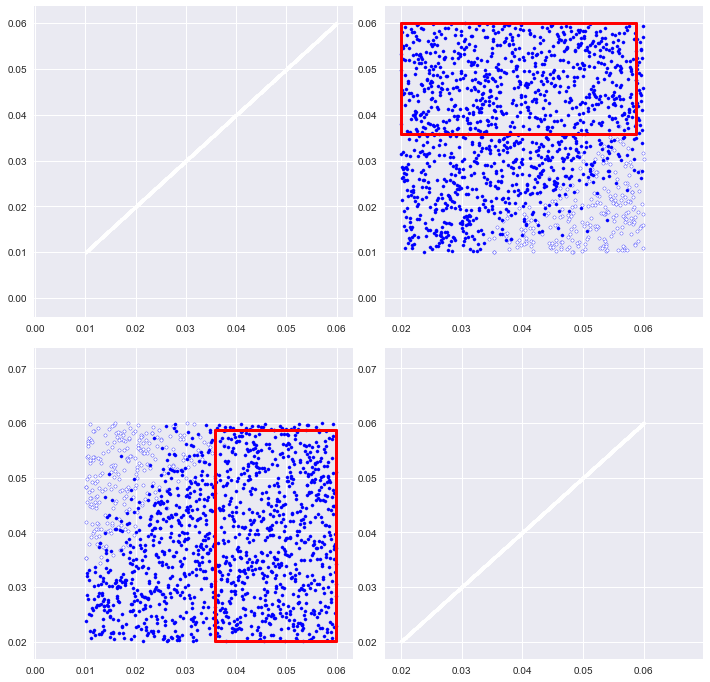

In [30]:
valuebox = 18
box_5.inspect(valuebox)
box_5.select(valuebox)

top_box = valuebox
box_5.inspect(top_box, style='graph')

fig = box_5.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [31]:
def classifyUrbanA(data):
    ooi = 'Urban Residential Land'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome<540] = 1
    return classes


prim_obj = prim.setup_prim(results, classifyUrbanA, threshold=0.8)
box_5 = prim_obj.find_box()

[MainProcess/INFO] 1500 points remaining, containing 1147 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.14533333333333334, coverage: 0.1900610287707062, density: 1.0 restricted_dimensions: 11


In [32]:
box_5.show_tradeoff()
mpld3.display()

coverage    0.512642
density      0.94686
mass           0.414
mean         0.94686
res dim            2
Name: 17, dtype: object

                                       box 17                        
                                          min       max     qp values
Base Non Economic Reconv rate        0.010010  0.028375  4.245476e-34
Average Residential approval period  0.500326  1.867376  1.557712e-01



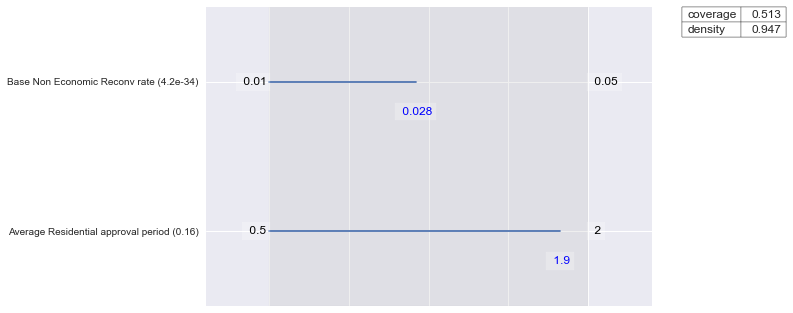

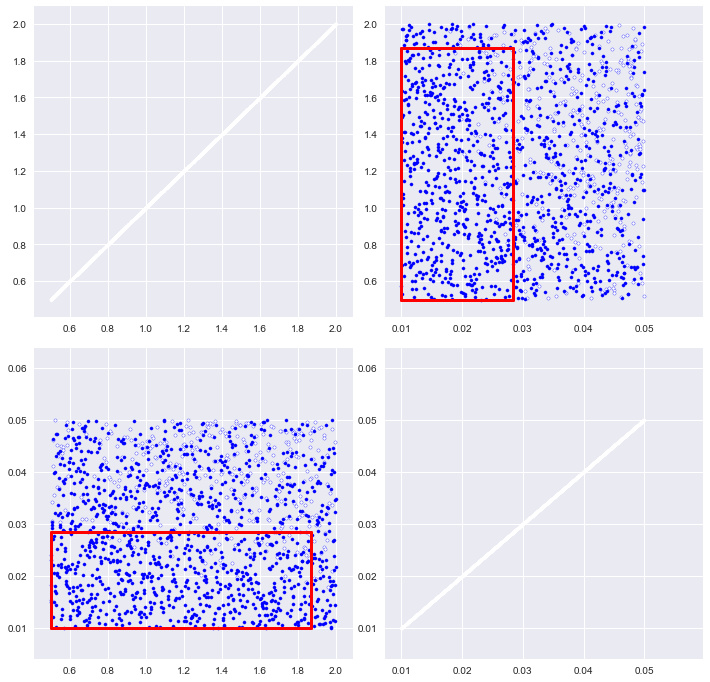

In [33]:
valuebox = 17
box_5.inspect(valuebox)
box_5.select(valuebox)

top_box = valuebox
box_5.inspect(top_box, style='graph')

fig = box_5.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [36]:
def classifySlumA(data):
    ooi = 'Slum Area'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>15] = 1
    return classes


prim_obj = prim.setup_prim(results, classifySlumA, threshold=0.8)
box_5 = prim_obj.find_box()

[MainProcess/INFO] 1500 points remaining, containing 1358 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.8133333333333334, coverage: 0.898379970544919, density: 1.0 restricted_dimensions: 1


In [37]:
box_5.show_tradeoff()
mpld3.display()

coverage    0.995582
density     0.948772
mass            0.95
mean        0.948772
res dim            1
Name: 1, dtype: object

                                box 1                        
                                  min       max     qp values
Base Slum reconversion rate  0.010027  0.057497  8.695083e-10



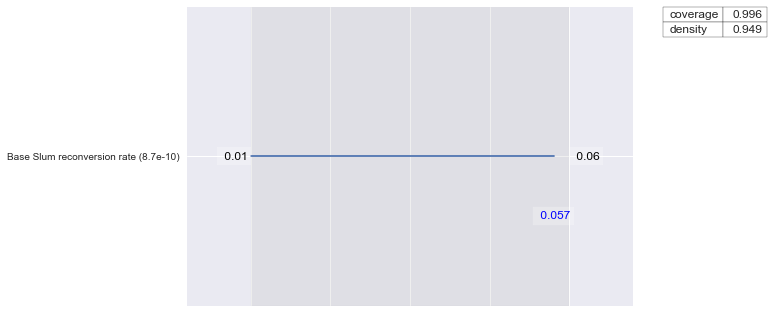

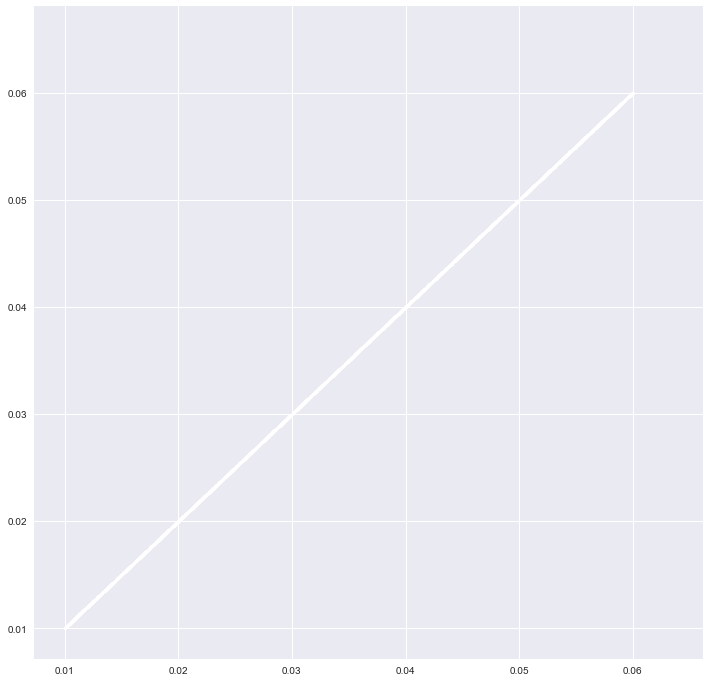

In [38]:
valuebox = 1
box_5.inspect(valuebox)
box_5.select(valuebox)

top_box = valuebox
box_5.inspect(top_box, style='graph')

fig = box_5.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()